
# Creditcard Fraud Detection with Deep Learning

**Author**: Serena Jin

This creditcard fraud detection will be implemented with autoencoder deep learning model.

Objective of choosing Autoencoder

Most of anomaly detection including creditcard fraud detection are now practised with traditional machine learning such as K-Nearest Neighbour, K-means, Support Vector Machine, Naive Bayes.

However it's challenging to practice creditcard fraud detection with traditional supervised ML models due to most of the transactions are normal, so it is difficult to obtain and accumulate a large number of abnormal samples to support supervised model training. For example, the creditcard tractions data set used in this project, has very unbalenced with normal and abnormal transactions. 

Aother considerable fact is that fraudsters often upgrade their own crimes to avoid the risk control system. From the data point of view, new fraud samples and training data distribution is quite different, and the training set samples are not able to represent the test set very well, which leads to over-fitting of the model and poor effect on the test set. Too few abnormal samples for supervised models will easily cause over-fitting resulted by data distribution. 

However, unsupervised learning models do not need to mark positive and negative samples, so unsupervise learning would be one of better models in this senario because unsupervised learning does not need to mark positive and negative samples which automatically extracts the meaningful features of our data, leverages the availability of unlabeled data, and adds a data-dependent regularization for training.

Autoencoder is an artificial neural network that trains models for data encoding in an unsupervised manner which includes two processes: encode and decode. The input data is processed by encode, the code is obtained, and the output is processed by decoding. We control the output dimension of the encode, which is equivalent to force the encode process to learn high-dimensional features with low-dimensional parameters. The purpose of the autoencoder is to make the input x and output x'.

The neural network trains end-to-end through a large number of data sets to continuously improve its accuracy. The Auto-Encoder method, as shown in the figure below, makes the input and output closer and closer by designing the encode and decode processes. This requires error backpropagation after each output to continuously optimize the entire network parameters.


![avatar](auto-encoder.PNG)

Lets start to use Keras autoencoder neural network with tesorflow backend

In [1]:
# Import all the required modules

%matplotlib inline
import pandas as pd
import numpy as np
from scipy import stats
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.metrics import recall_score, classification_report, auc, roc_curve
from sklearn.metrics import precision_recall_fscore_support, f1_score
from sklearn.preprocessing import StandardScaler
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers
import os
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")


Using TensorFlow backend.


In [2]:
# Load data
df = pd.read_csv('filtered_transactions.csv', encoding ='utf8')

In [3]:
# try by droping columns to compare the results
df = df.drop(['merchantCountryCode', 'customerId', 'transactionDate', 'transactionHour',
             'transactionTime', 'transactionDayofWeek', 'transactionDateDays'], axis=1)


In [4]:
# Reed n rows of data, 5 rows by defalt
df.head()

,accountNumber,acqCountry,availableMoney,cardCVV,cardLast4Digits,cardPresent,creditLimit,currentBalance,currentExpDate,dateOfLastAddressChange,enteredCVV,isFraud,merchantCategoryCode,merchantName,posConditionCode,posEntryMode,transactionAmount,transactionDateTime,transactionType
0,733493772,3,5000.00,492,9184,0,5000.0,0.00,0,0,492,1,5,1066,1.0,5.0,111.33,0,1
1,733493772,3,4888.67,492,9184,0,5000.0,111.33,1,0,492,0,5,2086,1.0,9.0,24.75,1,1
2,733493772,3,4863.92,492,9184,0,5000.0,136.08,2,0,492,0,5,1066,1.0,5.0,187.40,2,1
3,733493772,3,4676.52,492,9184,0,5000.0,323.48,3,0,492,1,5,1066,1.0,2.0,227.34,3,1
4,733493772,3,4449.18,492,9184,0,5000.0,550.82,4,0,492,0,5,1066,1.0,2.0,0.00,4,2


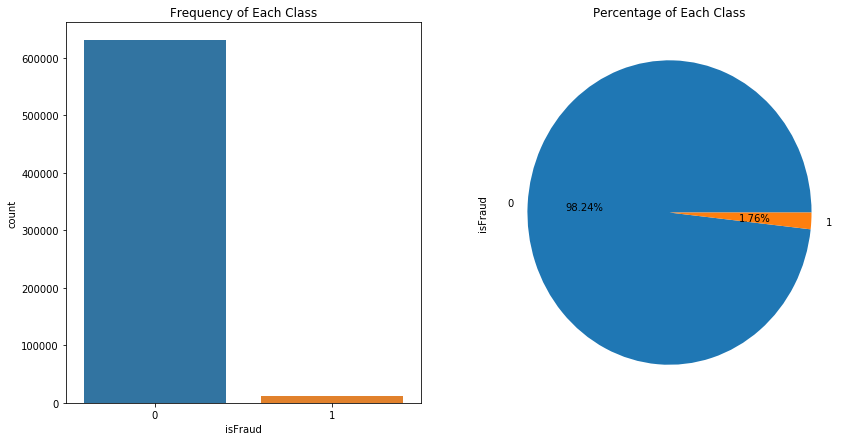

In [5]:
# View again the imbalanced Class distributiont before starting unsupervised learning below 

fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='isFraud',data=df,ax=axs[0])
axs[0].set_title("Frequency of Each Class")
df['isFraud'].value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of Each Class")
plt.show()


In [6]:
# Information about index dtype and column dtypes, non-null values and memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 641914 entries, 0 to 641913
Data columns (total 24 columns):
accountNumber              641914 non-null int64
acqCountry                 641914 non-null int64
availableMoney             641914 non-null float64
cardCVV                    641914 non-null int64
cardLast4Digits            641914 non-null int64
cardPresent                641914 non-null int64
creditLimit                641914 non-null float64
currentBalance             641914 non-null float64
currentExpDate             641914 non-null int64
dateOfLastAddressChange    641914 non-null int64
enteredCVV                 641914 non-null int64
isFraud                    641914 non-null int64
merchantCategoryCode       641914 non-null int64
merchantName               641914 non-null int64
posConditionCode           641914 non-null float64
posEntryMode               641914 non-null float64
transactionAmount          641914 non-null float64
transactionDateTime        641914 non-null i

In [6]:
"""
   Data normalization with feature scaling
   Feature scaling helps to normalise the data within a particular range. Sometimes, 
   it also helps in speeding up the calculations in an algorithm.
"""
scaleCol = ['accountNumber', 'acqCountry', 'availableMoney', 'cardCVV', 
          'cardLast4Digits', 'cardPresent', 'creditLimit', 'currentBalance', 'currentExpDate',
          'dateOfLastAddressChange', 'enteredCVV', 'merchantCategoryCode', 
           'merchantName', 'posConditionCode', 'posEntryMode', 
           'transactionAmount', 'transactionDateTime', 'transactionType']

# Initialize the scaler
sc = StandardScaler() 
# Standardize the data
df[scaleCol] =sc.fit_transform(df[scaleCol])

In [7]:
# create model and log directory for saving modes and logs

data_dir = './model'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    
log_dir = './log'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

# load the training and testing data

RANDOM_SEED = 42

# use sklearn train_test_split module to split train and test data
X_train, X_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
X_train = X_train[X_train.isFraud == 0]
X_train = X_train.drop(['isFraud'], axis=1)
y_test = X_test['isFraud']
X_test = X_test.drop(['isFraud'], axis=1)
X_train = X_train.values
X_test = X_test.values


# How Autoencoder predict test set when the data set has no label?

This model will be trained with both positive and negative data (i.e. frauds and non-frauds), without providing the labels. Since we have much more normal transactions than fraudulent ones, we should expect the model to learn and memorize the patterns of normal ones after training, and should be able to give a score for any transaction as being an outlier. And this unsupervised training would be quite useful in practice especially when we do not have enough labeled data set.

Autoencoder uses threshold by setting the reconstruction MSE/MAE threshold

There are two steps here:

1. Unsupervised learning, train an autoencoder to get the MSE score. MSE=autoencoder(x). There is only input x in loss and no label y.

2. Then get a binary classifier based on MSE, the purpose is to determine a threshold to minimize the overall error. For example, the horizontal axis in the figure below is MSE. The ultimate goal is to minimize the weighted sum of type I and type II errors.


![avatar](01.PNG)

In [8]:
"""
  Start building and training the model, four fully connected hidden layers were designed 
  with 22,11,11,45 number of nodes for each layer. 
  First two layers are for the encoder and last two for the decoder.
"""
input_dim = X_train.shape[1] # number of input columns
encoding_dim = 22
input_layer = Input(shape=(input_dim, ))
encoder = Dense(encoding_dim, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)
decoder = Dense(int(encoding_dim / 2), activation='tanh')(encoder)
decoder = Dense(input_dim, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Use 100 epoch and 32 samples each time entered the neural network for training.

epoch_nb = 100
batch_size = 32

"""
  For optimizer, we use adaptive learning rate optimization algorithm that’s been designed 
  specifically for training deep neural networks.
  For loss function, we use mean_squred_error, the error between output and x is commonly measured using root mean square error 
  (RMSE) – mean((f(x) – x) ^ 2) – which is the loss function we try to minimise in our network.
  
"""
autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

cp = ModelCheckpoint(filepath="model/autoencoder_fraud.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./log',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

history = autoencoder.fit(X_train, X_train, epochs=epoch_nb, batch_size=batch_size,
                          shuffle=True, validation_data=(X_test, X_test), verbose=1,
                          callbacks=[cp, tb]).history

Train on 504518 samples, validate on 128383 samples
Epoch 1/100
504518/504518 [==============================] - 14s 27us/step - loss: 0.4423 - acc: 0.7880 - val_loss: 0.4014 - val_acc: 0.8699
Epoch 2/100
504518/504518 [==============================] - 13s 26us/step - loss: 0.3967 - acc: 0.8901 - val_loss: 0.3970 - val_acc: 0.8595
Epoch 3/100
504518/504518 [==============================] - 14s 28us/step - loss: 0.3953 - acc: 0.8932 - val_loss: 0.3950 - val_acc: 0.9220
Epoch 4/100
504518/504518 [==============================] - 14s 27us/step - loss: 0.3946 - acc: 0.8941 - val_loss: 0.3950 - val_acc: 0.9210
Epoch 5/100
504518/504518 [==============================] - 15s 29us/step - loss: 0.3943 - acc: 0.8959 - val_loss: 0.3964 - val_acc: 0.9053
Epoch 6/100
504518/504518 [==============================] - 13s 26us/step - loss: 0.3940 - acc: 0.8964 - val_loss: 0.3954 - val_acc: 0.9162
Epoch 7/100
504518/504518 [==============================] - 13s 26us/step - loss: 0.3935 - acc: 0.898

In [19]:
autoencoder = load_model('model/autoencoder_fraud.h5')

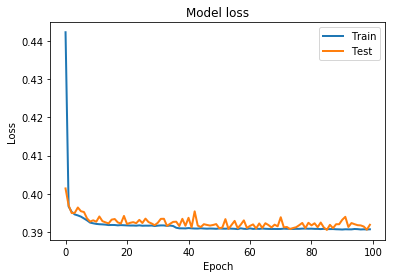

In [20]:
# View the loss by epoch
plt.plot(history['loss'], linewidth=2, label='Train')
plt.plot(history['val_loss'], linewidth=2, label='Test')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

In [21]:
# View the reconstruction error
test_x_predictions = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - test_x_predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse,
                        'True_class': y_test})
error_df.describe()

,Reconstruction_error,True_class
count,128383.000000,128383.000000
mean,0.387985,0.017829
std,0.701469,0.132332
min,0.010158,0.000000
25%,0.223201,0.000000
50%,0.311913,0.000000
75%,0.425577,0.000000
max,13.680600,1.000000


The model currently trained by autoncoder cannot be used to predict new samples. In order to give a normal or fraudulent judgment on a new sample, We need to calculate the reconstruction error for the new sample. If this error is greater than a predetermined threshold, we will judge it as fraud. The threshold can be set between 0.2 and 0.24. If you do not know the positive class or negative class label, you can set it by calculating the quantile of the reconstruction error of the whole sample.

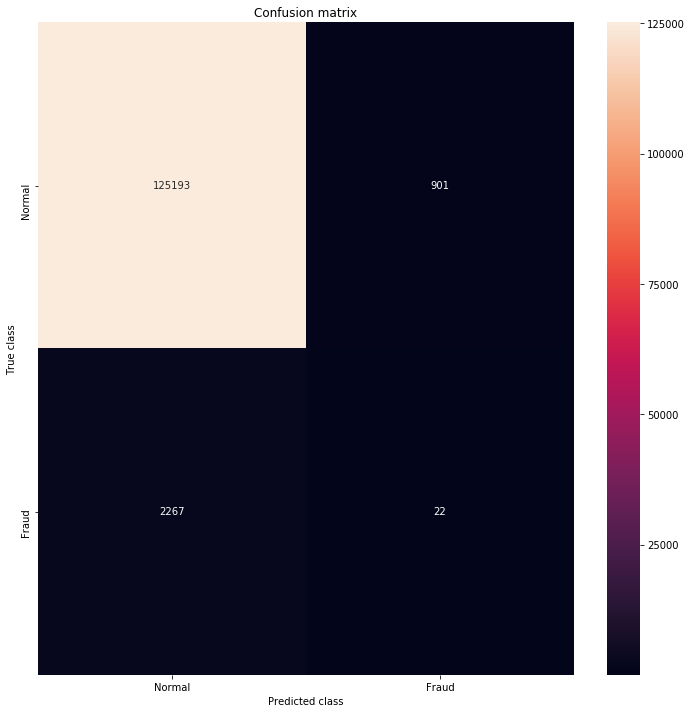

In [24]:
# Confusion Matrix 
threshold_fixed= 5
LABELS = ["Normal","Fraud"]
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

# Conclusion

In this creditcard anomaly detection model, I used unsupervised learning through autoencoder on one of the Creditcard transaction datasets. The model in general needs to be improved  through observing the trend of the reconstruction error curve on the training set and the test set.

It can be seen that the reconstruction error curve has a small decrease and does not tend to converge stably. It can be considered that the model is still under-fitting. It should be due to the small sample size used for training. 

How to improve this model?

Need spend more time on hyper paramer tunning and there are many details should need aware, such as the balance between the complexity of the neural network and the number of samples in the training set, to ensure that the model has a good enough approximation in the training process; Processing, including correlation deduplication, denoising and other operations. In deep learning, there are also better processing mechanisms for categorical types than for one-hot encoding. 

As I mentioned in the above, unsupervised learning autoencoder can detect new types of fraud in a more timely manner than the traditional supervised models which might be hard to solve newly formed fraud patterns.
